##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

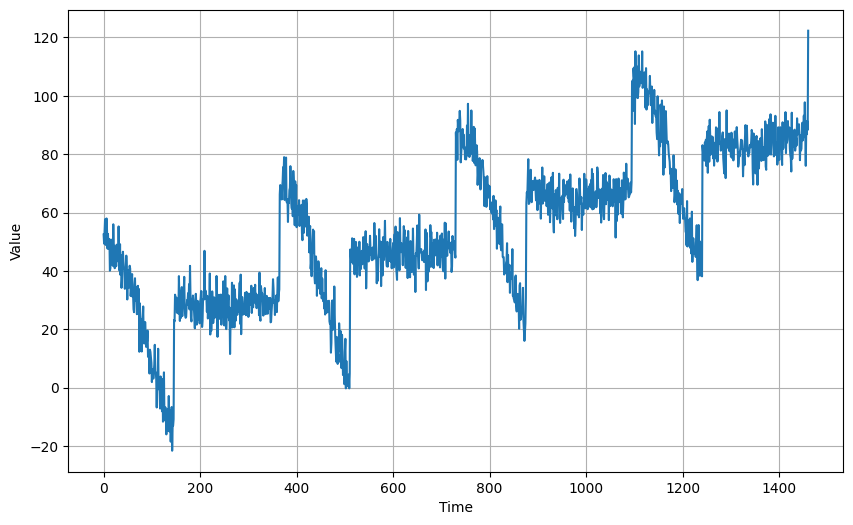

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 351ms/step - loss: 52.3087 - mae: 52.8083 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 86ms/step - loss: 21.8880 - mae: 22.3826 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 79ms/step - loss: 22.4838 - mae: 22.9766 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 68ms/step - loss: 18.0948 - mae: 18.5876 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 75ms/step - loss: 17.0092 - mae: 17.5029 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 89ms/step - loss: 15.7584 - mae: 16.2468 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 85ms/step - loss: 14.8509 - mae: 15.3437 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 2s 122ms/step - loss: 14.4937 - mae: 14.9802 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 2s 139ms/step - loss: 14.0566 - mae: 14.5478 - lr: 

(1e-07, 0.0001, 0.0, 30.0)

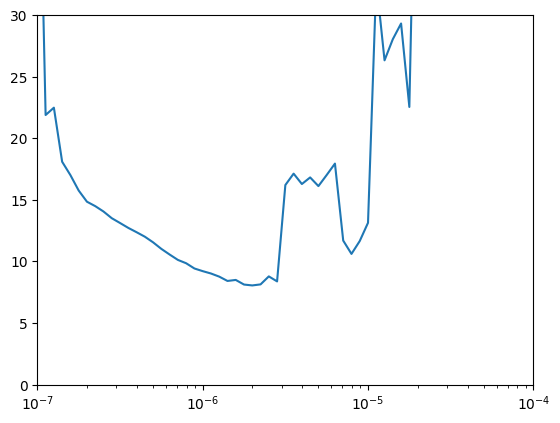

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 3s 60ms/step - loss: 16646.9844 - mae: 16647.4844

8/8 [==============================] - 8s 703ms/step - loss: 16646.9844 - mae: 16647.4844 - val_loss: 10060.9131 - val_mae: 10061.4131
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 22674.6523 - mae: 22675.1504

8/8 [==============================] - 5s 631ms/step - loss: 22674.6523 - mae: 22675.1504 - val_loss: 1167.2738 - val_mae: 1167.7738
Epoch 3/500
8/8 [==============================] - 1s 59ms/step - loss: 26308.2305 - mae: 26308.7305 - val_loss: 56652.6133 - val_mae: 56653.1133
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 42600.6367 - mae: 42601.1328 - val_loss: 8335.3379 - val_mae: 8335.8379
Epoch 5/500
8/8 [==============================] - 1s 65ms/step - loss: 19284.3027 - mae: 19284.8047 - val_loss: 14004.5449 - val_mae: 14005.0449
Epoch 6/500
8/8 [==============================] - 1s 73ms/step - loss: 63442.3125 - mae: 63442.8125 - val_loss: 55908.9180 - val_mae: 55909.4219
Epoch 7/500
8/8 [==============================] - 1s 62ms/step - loss: 57437.7461 - mae: 57438.2422 - val_loss: 48486.9180 - val_mae: 48487.4219
Epoch 8/500
8/8 [==============================] - 1s 59ms/step - loss: 60109.7852 - mae: 60110.2891 - val_loss: 45135.3164 - val_mae: 4513

In [10]:
model = keras.models.load_model("my_checkpoint")

In [11]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 14ms/step


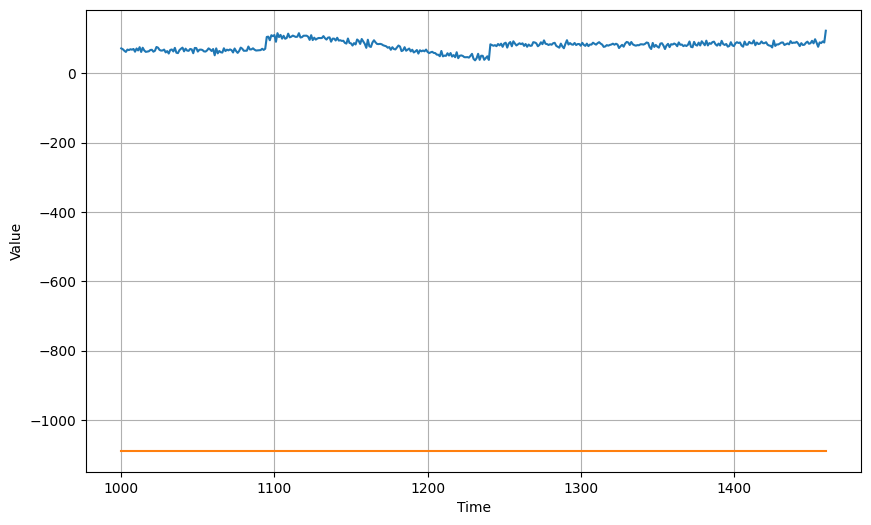

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1166.9584

## Sequence-to-Sequence Forecasting

In [14]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 84ms/step - loss: 233.0479 - mae: 233.5479 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 52ms/step - loss: 194.9098 - mae: 195.4098 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 50ms/step - loss: 134.6512 - mae: 135.1512 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 51ms/step - loss: 62.0458 - mae: 62.5447 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 42ms/step - loss: 37.3315 - mae: 37.8291 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 41ms/step - loss: 34.2243 - mae: 34.7218 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 46ms/step - loss: 28.1592 - mae: 28.6535 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 46ms/step - loss: 25.1152 - mae: 25.6067 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 48ms/step - loss: 23.9872 - mae: 24.4771 - l

(1e-07, 0.0001, 0.0, 30.0)

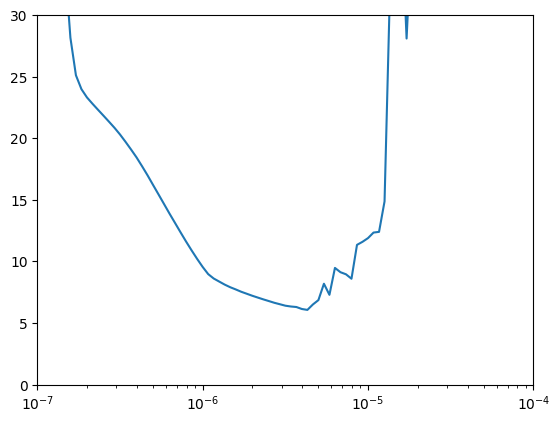

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 114ms/step - loss: 16949.6172 - mae: 16950.1172 - val_loss: 58367.1328 - val_mae: 58367.6328
Epoch 2/500
8/8 [==============================] - 1s 64ms/step - loss: 36816.0703 - mae: 36816.5742 - val_loss: 59091.4297 - val_mae: 59091.9258
Epoch 3/500
8/8 [==============================] - 1s 71ms/step - loss: 31754.5020 - mae: 31755.0039 - val_loss: 1926.3771 - val_mae: 1926.8771
Epoch 4/500
8/8 [==============================] - 1s 65ms/step - loss: 31349.6934 - mae: 31350.1895 - val_loss: 35065.1211 - val_mae: 35065.6211
Epoch 5/500
8/8 [==============================] - 1s 127ms/step - loss: 37715.3398 - mae: 37715.8359 - val_loss: 20847.2578 - val_mae: 20847.7578
Epoch 6/500
8/8 [==============================] - 1s 103ms/step - loss: 22400.4668 - mae: 22400.9648 - val_loss: 52225.6836 - val_mae: 52226.1836
Epoch 7/500
8/8 [==============================] - 1s 59ms/step - loss: 38195.8633 - mae: 38196.3594 - val_loss: 29243.7402

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 13ms/step


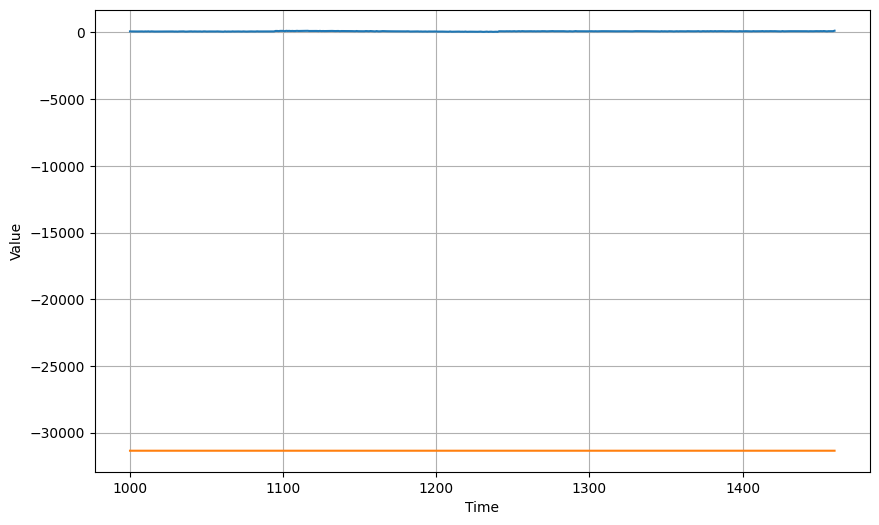

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

31430.434